In [1]:
import torch
import torchvision
from torchvision import transforms
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import pickle
from tqdm import tqdm
import pandas as pd
import random

import timm
from torch.utils.tensorboard import SummaryWriter


DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

In [2]:
from torch.nn.modules.container import Sequential
from torchvision.models.resnet import Bottleneck
from torchvision.models.vision_transformer import EncoderBlock

In [3]:
# using the validation transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

## Randomly subsample features too

data_path='/datasets01/imagenet_full_size/061417/'
dataset = torchvision.datasets.ImageFolder(data_path + 'val', transform=transform)

# ViT vs ResNet (sanity checks)

In [4]:
vit_b_32 = torchvision.models.vit_b_32(pretrained=True)
vit_l_16 = torchvision.models.vit_l_16(pretrained=True)
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet152 = torchvision.models.resnet152(pretrained=True)

In [5]:
#%%time


t_layers  = ([name for name, module in vit_b_32.named_modules()
              if 'drop' not in name and 'out_proj' not in name and name != '' 
              and not isinstance(module, Sequential) and not isinstance(module, EncoderBlock)])
t_layers = np.random.choice(t_layers, 10)
modt_hooks = [HookedCache(vit_b_32, name) for name in t_layers]

c_layers  = ([name for name, module in resnet50.named_modules() \
              if 'drop' not in name and name != '' and name != '' \
              and not isinstance(module, Sequential) and not isinstance(module, Bottleneck)])
c_layers = np.random.choice(c_layers, 10)
modc_hooks = [HookedCache(vit_b_32, name) for name in t_layers]

In [6]:
vit_b_32.to(DEVICE)
resnet50.to(DEVICE)

resnet50.eval()
vit_b_32.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [7]:
log_every = 10
do_log = True

### Sweep over different dataset sizes

In [2]:
sample_sizes = [128*(2**i) for i in range(0, 4)] + [512*i for i in range(3, 21)]

sim_mat_cc = {i:None for i in sample_sizes}
sim_mat_tt = {i:None for i in sample_sizes}
sim_mat_ct = {i:None for i in sample_sizes}

In [ ]:
for i in tqdm(sample_sizes):

    print('Sample size:', i)

    indexes = np.random.uniform(low=0, high=len(dataset), size=i).astype(int)
    subset = torch.utils.data.Subset(dataset, indexes)

    data_loader = torch.utils.data.DataLoader(subset,
                                          batch_size=128,
                                          shuffle=False,
                                          pin_memory=False)

    metrics_ct = make_pairwise_metrics(modc_hooks, modt_hooks, device=DEVICE)
    metrics_cc = make_pairwise_metrics(modc_hooks, modc_hooks, device=DEVICE)
    metrics_tt = make_pairwise_metrics(modt_hooks, modt_hooks, device=DEVICE)

    with torch.no_grad():
    
        for it, [batch, label] in enumerate(data_loader):
            batch = batch.to(DEVICE)
            do_log =  (it % log_every == 0)
            if do_log:
               logger.debug(f"iter: {it}")
            outv_c = resnet50(batch)
            outv_t = vit_b_32(batch)

            update_metrics(modc_hooks, modt_hooks, metrics_ct, "cka/ct", do_log,  device=DEVICE)
            update_metrics(modc_hooks, modc_hooks, metrics_cc, "cka/cc", do_log,  device=DEVICE)
            update_metrics(modt_hooks, modt_hooks, metrics_tt, "cka/tt", do_log,  device=DEVICE)
                
            for hook0 in modc_hooks:
                for hook1 in modt_hooks:
                    hook0.clear()
                    hook1.clear()

    sim_mat_cc[i] = get_simmat_from_metrics(metrics_cc)
    sim_mat_tt[i] = get_simmat_from_metrics(metrics_tt)
    sim_mat_ct[i] = get_simmat_from_metrics(metrics_ct)

In [3]:
with open('sim_mat_tt.pkl', 'rb') as f:
    sim_mat_tt = pickle.load(f)

with open('sim_mat_ct.pkl', 'rb') as f:
    sim_mat_ct = pickle.load(f)

with open('sim_mat_cc.pkl', 'rb') as f:
    sim_mat_cc = pickle.load(f)

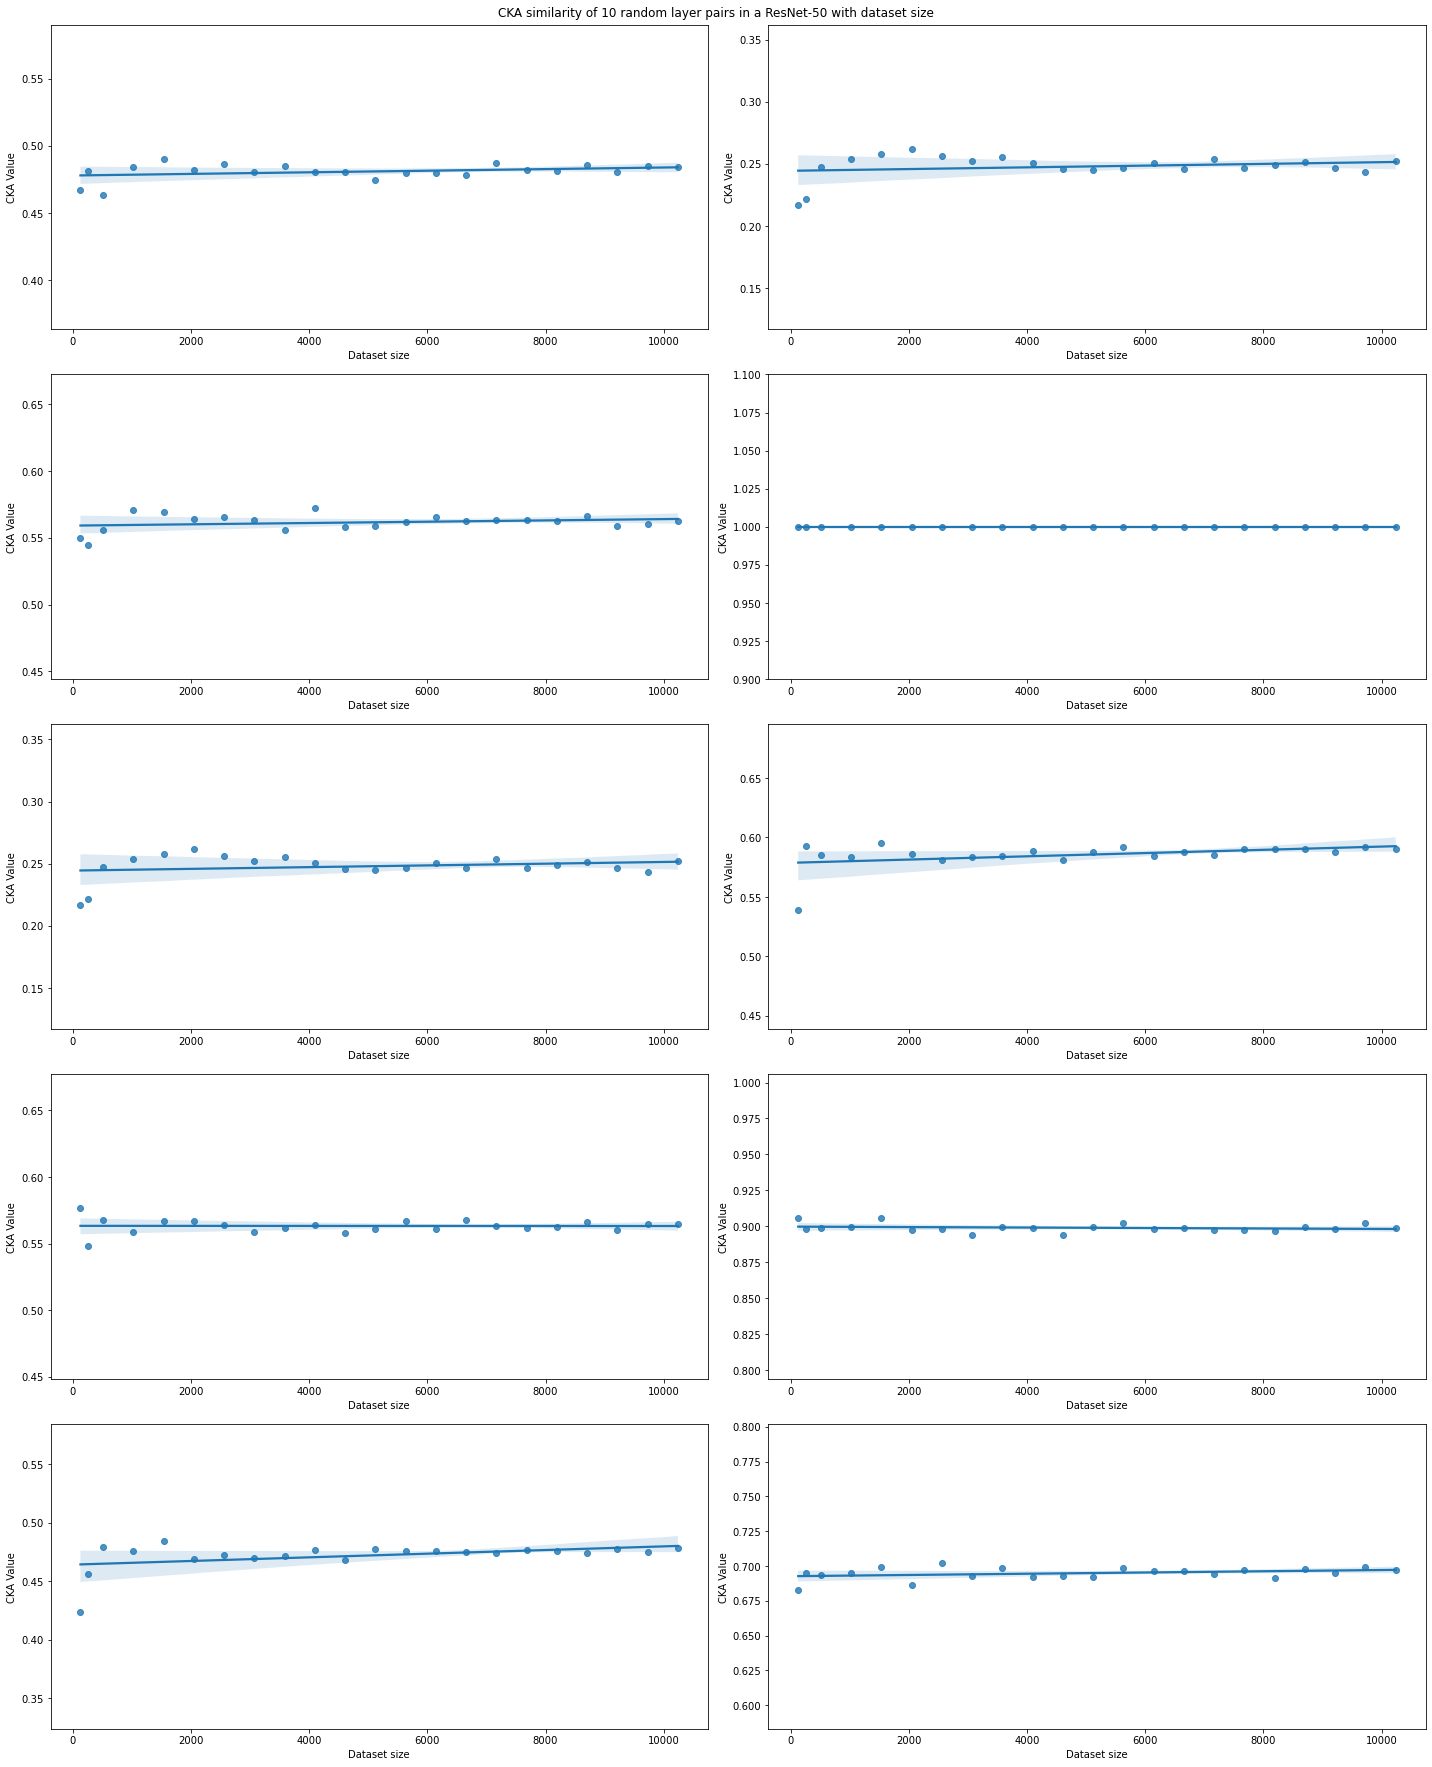

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(20,25))
fig.suptitle('CKA similarity of 10 random layer pairs in a ResNet-50 with dataset size')

for fig_num in range(10):

    i = random.randint(0, 9)
    j = random.randint(0, 9)

    x = [k for k in sim_mat_cc]
    y = [sim_mat_cc[k][i][j].item() for k in sim_mat_cc]

    df = pd.DataFrame({'Dataset size': x, 'CKA Value': y})

    sns.regplot(ax = axes[fig_num%5][int(fig_num/5)], x='Dataset size', y='CKA Value', data=df)
    axes[fig_num%5][int(fig_num/5)].set(ylim=(min(y)-0.1, max(y)+0.1))

fig.tight_layout()
fig.subplots_adjust(top=0.97)

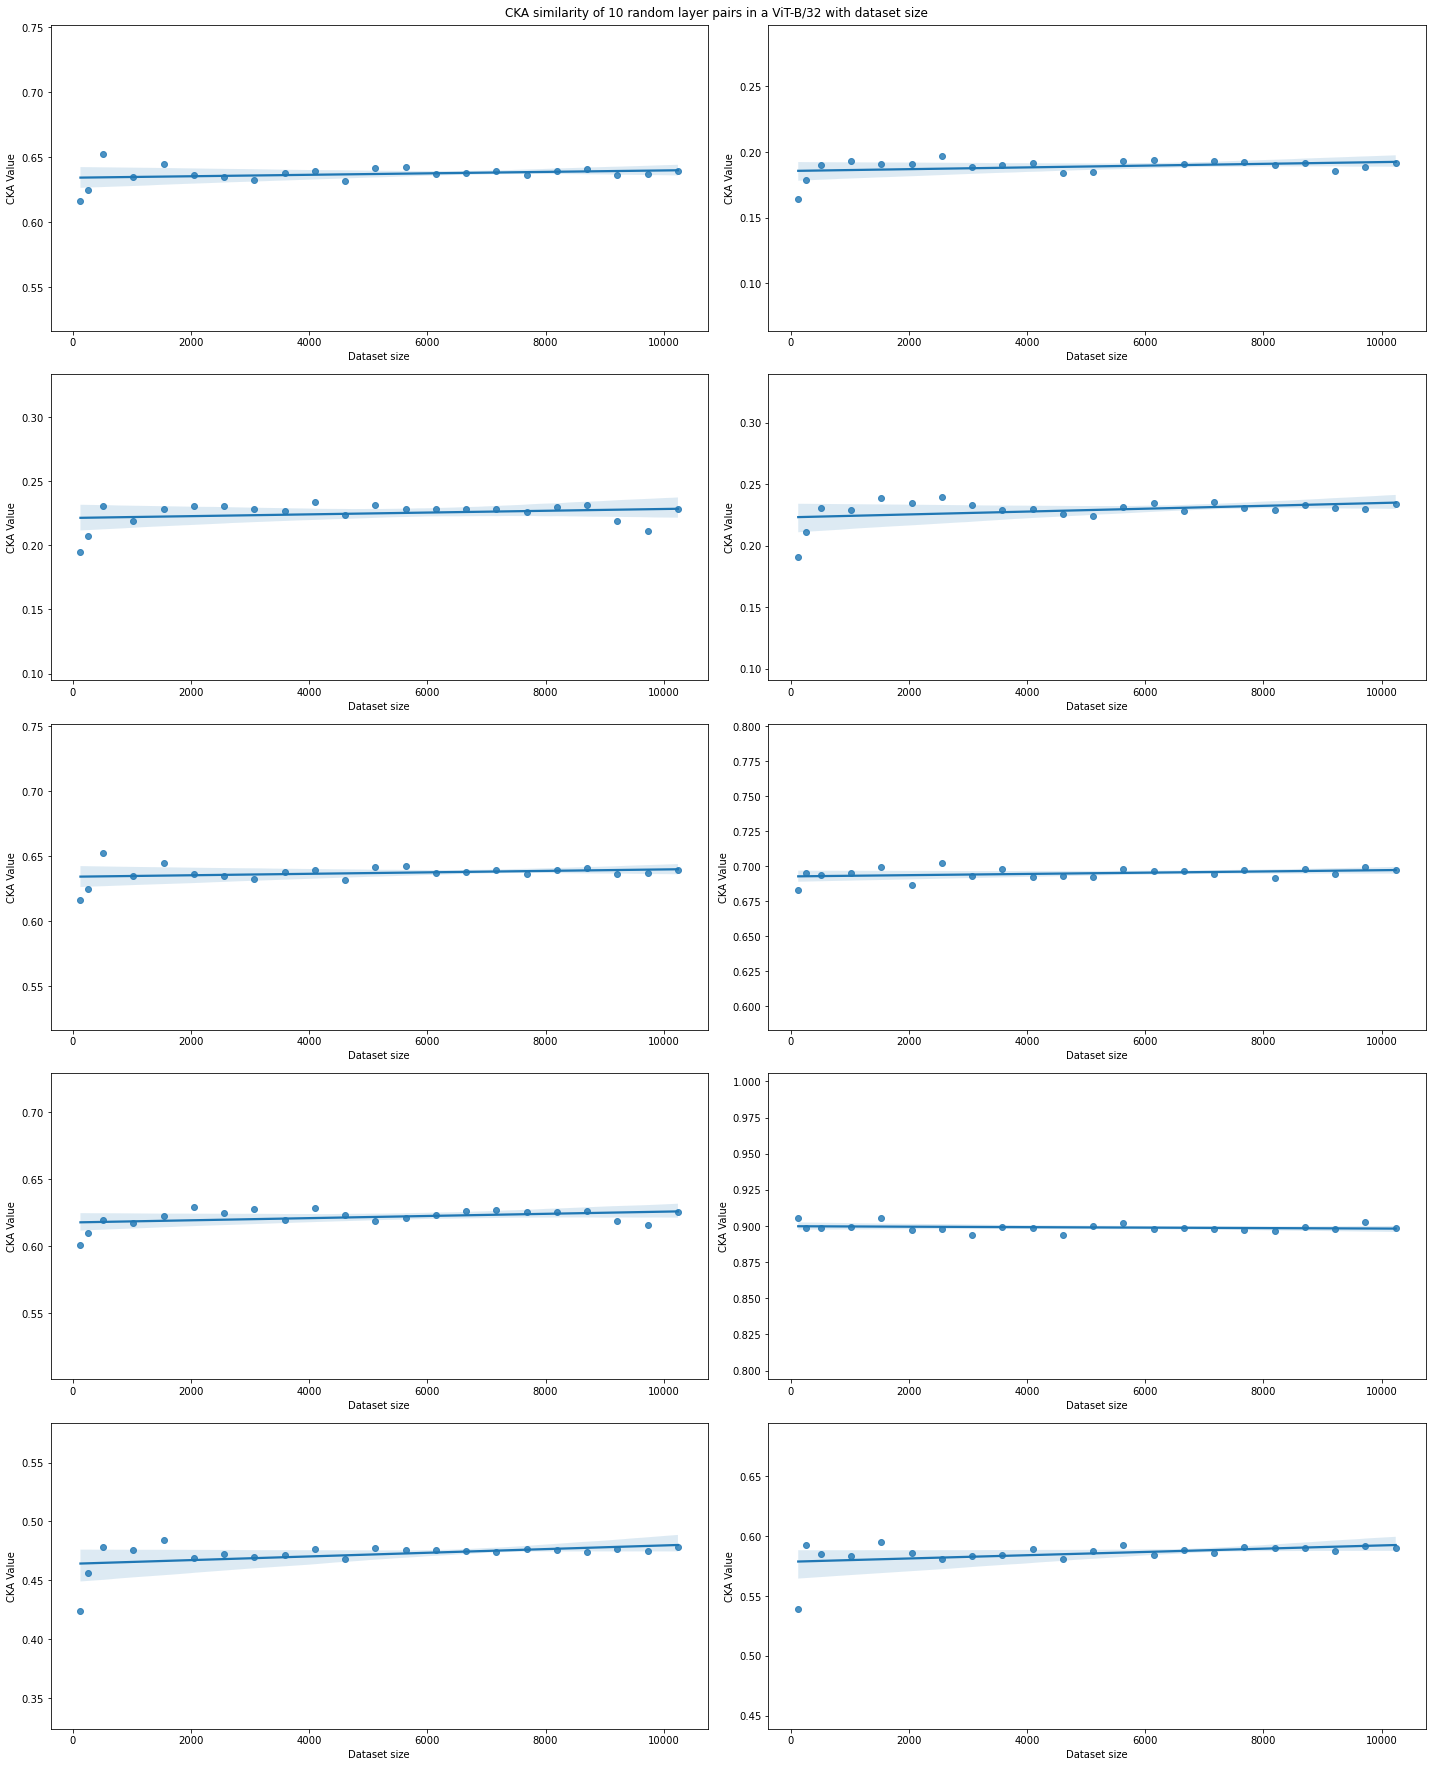

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(20,25))
fig.suptitle('CKA similarity of 10 random layer pairs in a ViT-B/32 with dataset size')

for fig_num in range(10):

    i = random.randint(0, 9)
    j = random.randint(0, 9)

    x = [k for k in sim_mat_tt]
    y = [sim_mat_tt[k][i][j].item() for k in sim_mat_tt]

    df = pd.DataFrame({'Dataset size': x, 'CKA Value': y})

    sns.regplot(ax = axes[fig_num%5][int(fig_num/5)], x='Dataset size', y='CKA Value', data=df)
    axes[fig_num%5][int(fig_num/5)].set(ylim=(min(y)-0.1, max(y)+0.1))

fig.tight_layout()
fig.subplots_adjust(top=0.97)

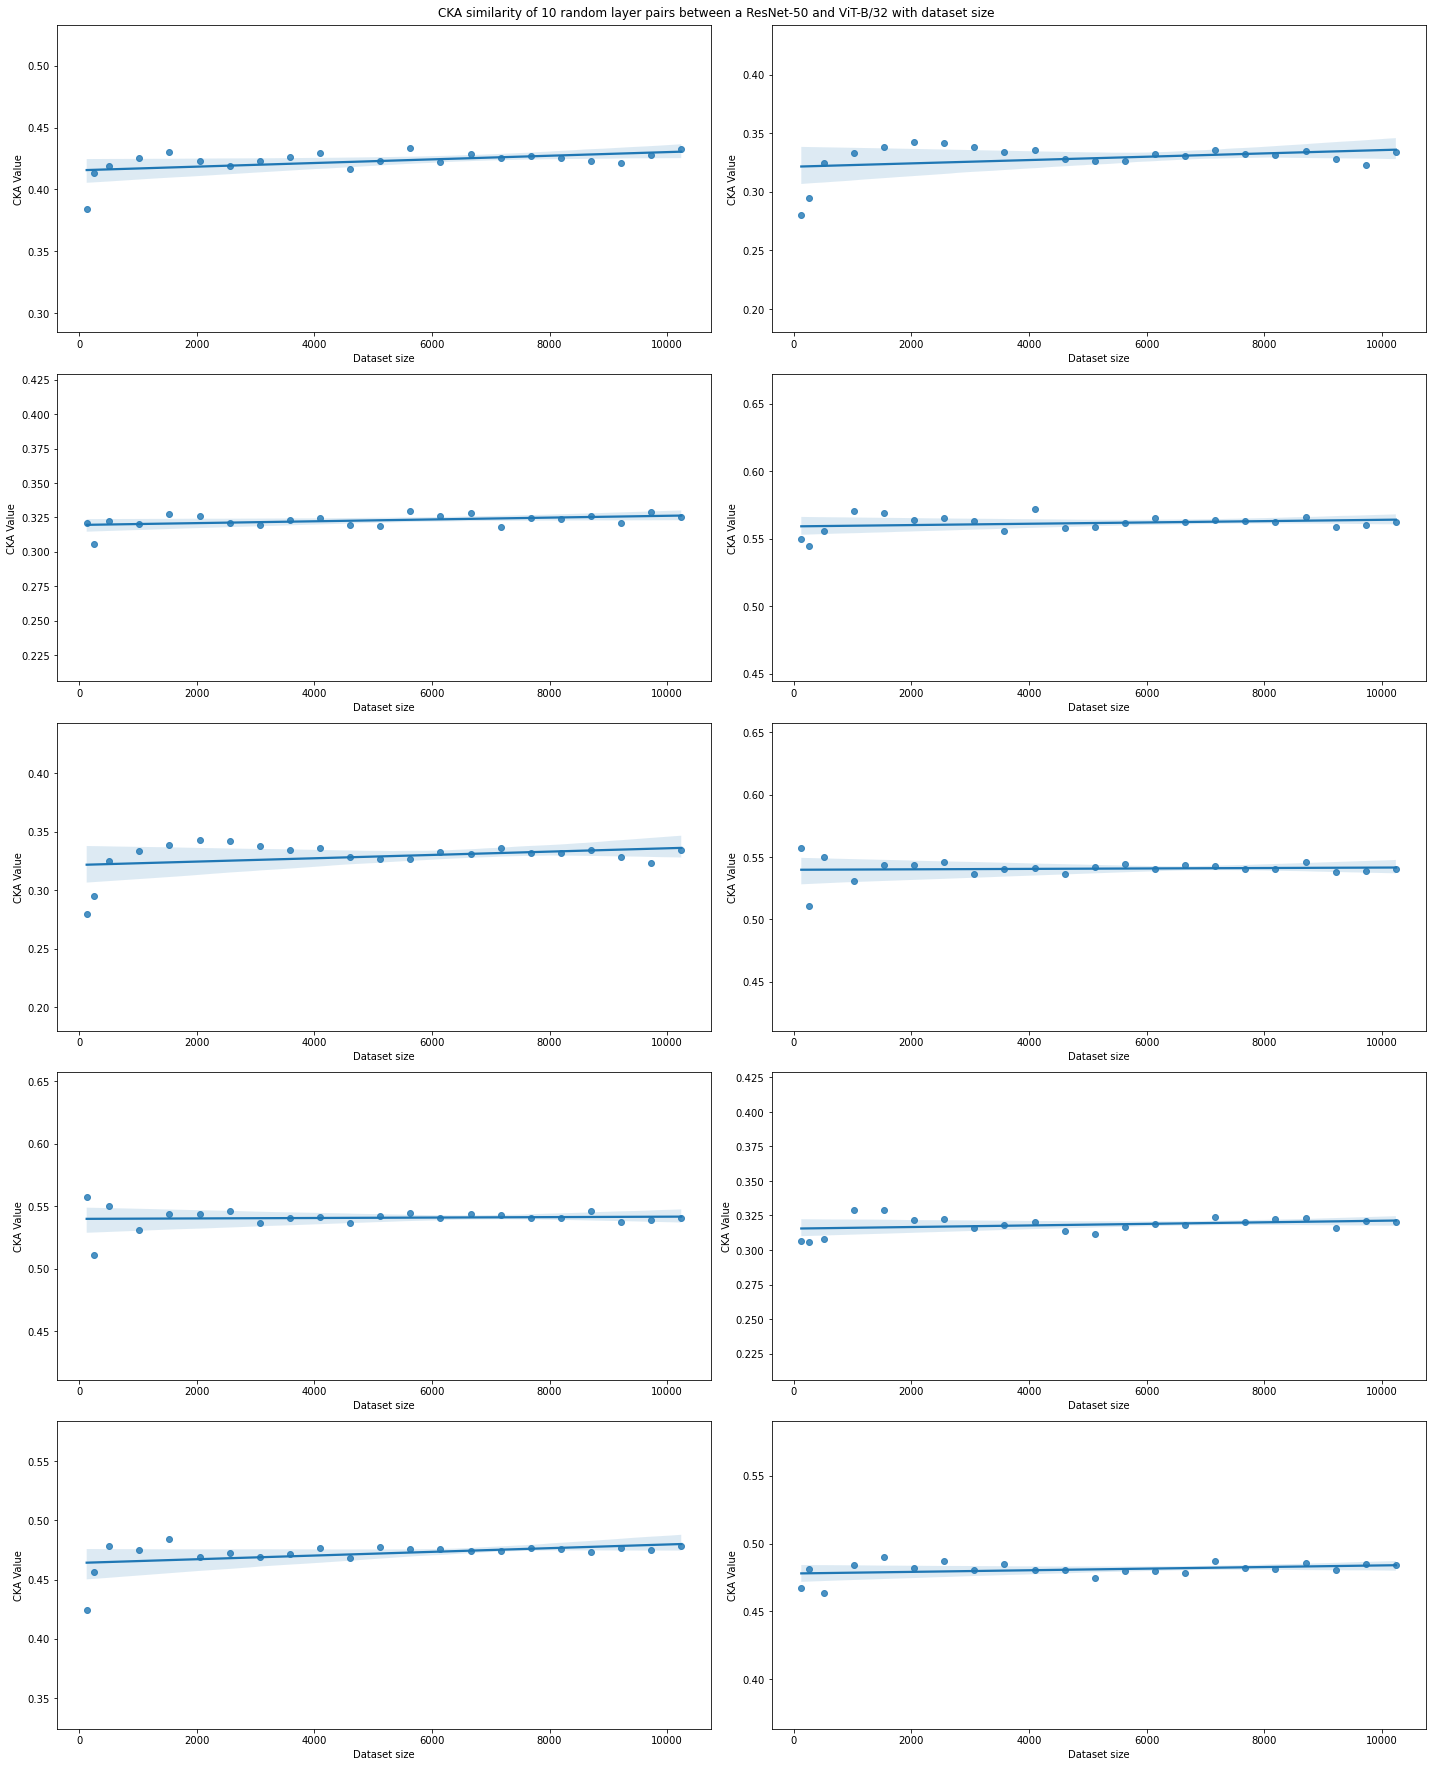

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(20,25))
fig.suptitle('CKA similarity of 10 random layer pairs between a ResNet-50 and ViT-B/32 with dataset size')

for fig_num in range(10):

    i = random.randint(0, 9)
    j = random.randint(0, 9)

    x = [k for k in sim_mat_ct]
    y = [sim_mat_ct[k][i][j].item() for k in sim_mat_ct]

    df = pd.DataFrame({'Dataset size': x, 'CKA Value': y})

    sns.regplot(ax = axes[fig_num%5][int(fig_num/5)], x='Dataset size', y='CKA Value', data=df)
    axes[fig_num%5][int(fig_num/5)].set(ylim=(min(y)-0.1, max(y)+0.1))

fig.tight_layout()
fig.subplots_adjust(top=0.97)

### Sweep over different batch sizes

In [2]:
batch_sizes = [32*(i) for i in range(1, 4)] + [128*(i) for i in range(1, 9)]

sim_mat_cc = {i:None for i in batch_sizes}
sim_mat_tt = {i:None for i in batch_sizes}
sim_mat_ct = {i:None for i in batch_sizes}

In [ ]:
for i in tqdm(batch_sizes):

    print('Batch size:', i)

    indexes = np.random.uniform(low=0, high=len(dataset), size=10240).astype(int)
    subset = torch.utils.data.Subset(dataset, indexes)

    data_loader = torch.utils.data.DataLoader(subset,
                                          batch_size=i,
                                          shuffle=False,
                                          pin_memory=False)

    metrics_ct = make_pairwise_metrics(modc_hooks, modt_hooks, device=DEVICE)
    metrics_cc = make_pairwise_metrics(modc_hooks, modc_hooks, device=DEVICE)
    metrics_tt = make_pairwise_metrics(modt_hooks, modt_hooks, device=DEVICE)

    with torch.no_grad():
    
        for it, [batch, label] in enumerate(data_loader):
            batch = batch.to(DEVICE)
            do_log =  (it % log_every == 0)
            if do_log:
               logger.debug(f"iter: {it}")
            outv_c = resnet50(batch)
            outv_t = vit_b_32(batch)

            update_metrics(modc_hooks, modt_hooks, metrics_ct, "cka/ct", do_log,  device=DEVICE)
            update_metrics(modc_hooks, modc_hooks, metrics_cc, "cka/cc", do_log,  device=DEVICE)
            update_metrics(modt_hooks, modt_hooks, metrics_tt, "cka/tt", do_log,  device=DEVICE)
                
            for hook0 in modc_hooks:
                for hook1 in modt_hooks:
                    hook0.clear()
                    hook1.clear()

    sim_mat_cc[i] = get_simmat_from_metrics(metrics_cc)
    sim_mat_tt[i] = get_simmat_from_metrics(metrics_tt)
    sim_mat_ct[i] = get_simmat_from_metrics(metrics_ct)

In [3]:
with open('sim_mat_tt_batch.pkl', 'rb') as f:
    sim_mat_tt = pickle.load(f)

with open('sim_mat_ct_batch.pkl', 'rb') as f:
    sim_mat_ct = pickle.load(f)

with open('sim_mat_cc_batch.pkl', 'rb') as f:
    sim_mat_cc = pickle.load(f)

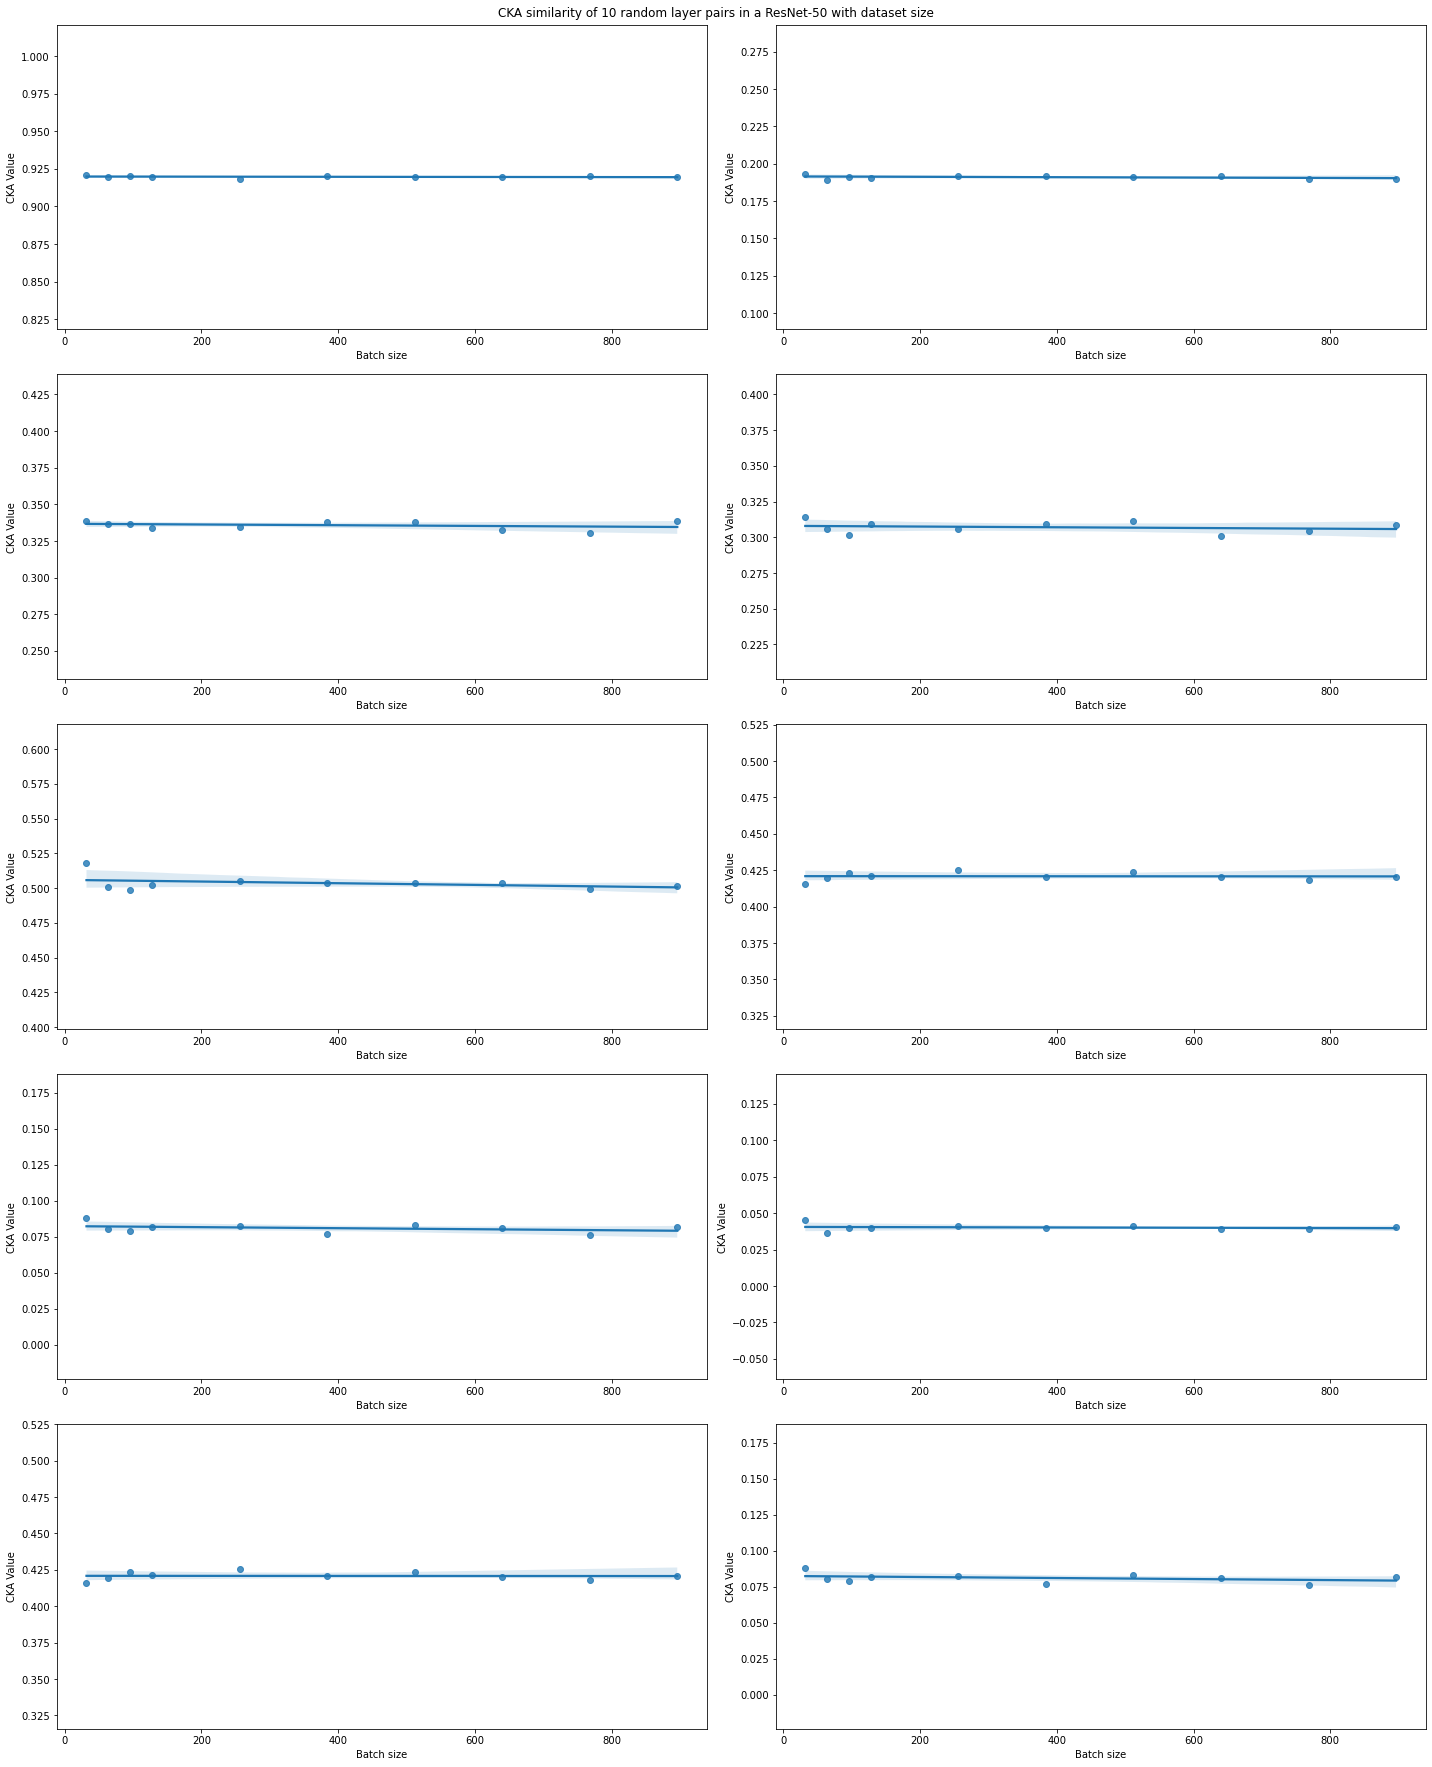

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(20,25))
fig.suptitle('CKA similarity of 10 random layer pairs in a ResNet-50 with dataset size')

for fig_num in range(10):

    i = random.randint(0, 9)
    j = random.randint(0, 9)

    x = [k for k in sim_mat_cc]
    y = [sim_mat_cc[k][i][j].item() for k in sim_mat_cc]

    df = pd.DataFrame({'Batch size': x, 'CKA Value': y})

    sns.regplot(ax = axes[fig_num%5][int(fig_num/5)], x='Batch size', y='CKA Value', data=df)
    axes[fig_num%5][int(fig_num/5)].set(ylim=(min(y)-0.1, max(y)+0.1))

fig.tight_layout()
fig.subplots_adjust(top=0.97)

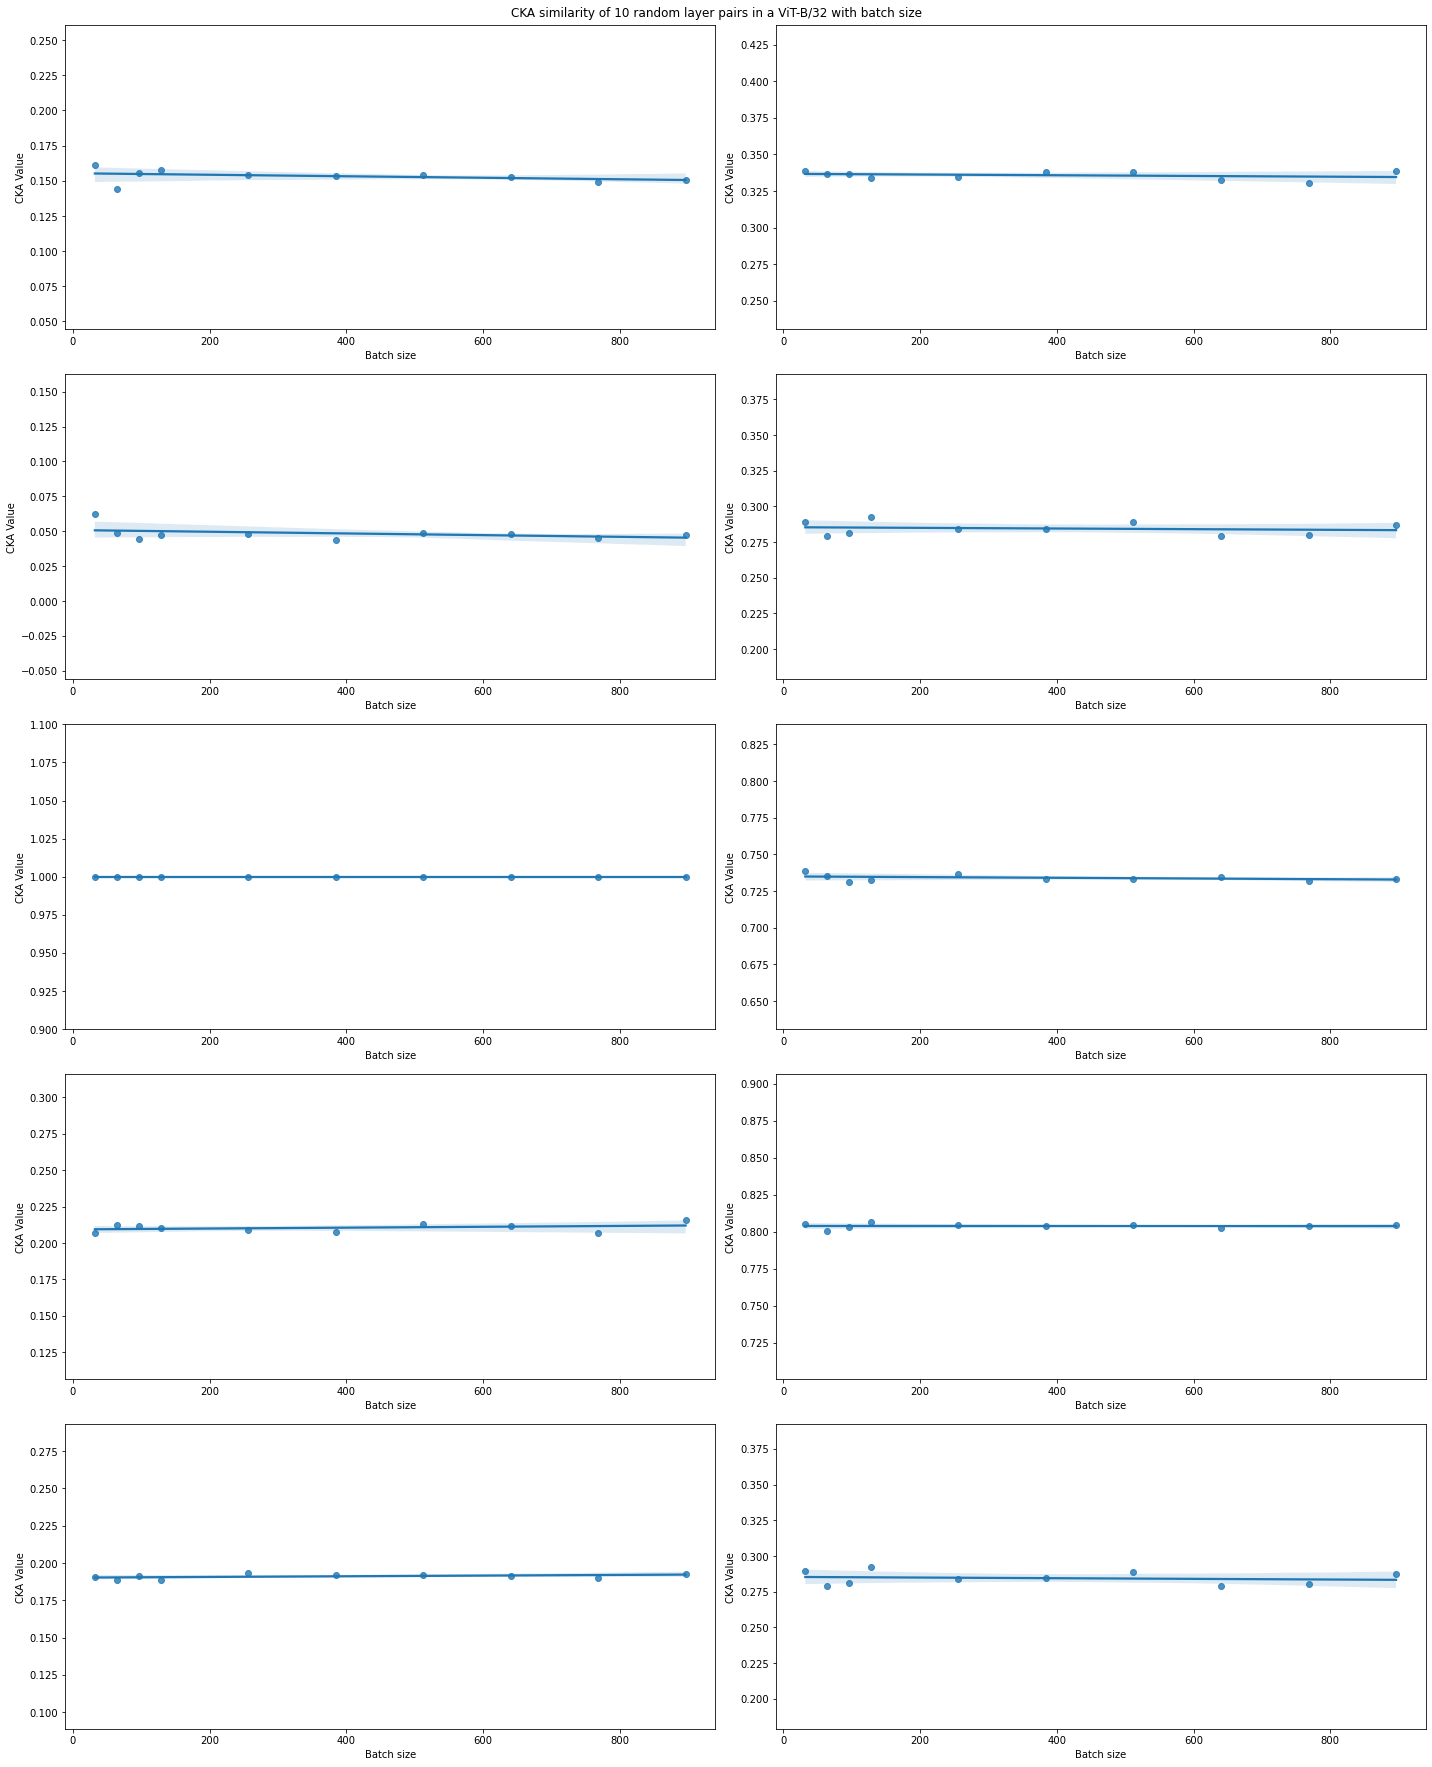

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(20,25))
fig.suptitle('CKA similarity of 10 random layer pairs in a ViT-B/32 with batch size')

for fig_num in range(10):

    i = random.randint(0, 9)
    j = random.randint(0, 9)

    x = [k for k in sim_mat_tt]
    y = [sim_mat_tt[k][i][j].item() for k in sim_mat_tt]

    df = pd.DataFrame({'Batch size': x, 'CKA Value': y})

    sns.regplot(ax = axes[fig_num%5][int(fig_num/5)], x='Batch size', y='CKA Value', data=df)
    axes[fig_num%5][int(fig_num/5)].set(ylim=(min(y)-0.1, max(y)+0.1))

fig.tight_layout()
fig.subplots_adjust(top=0.97)

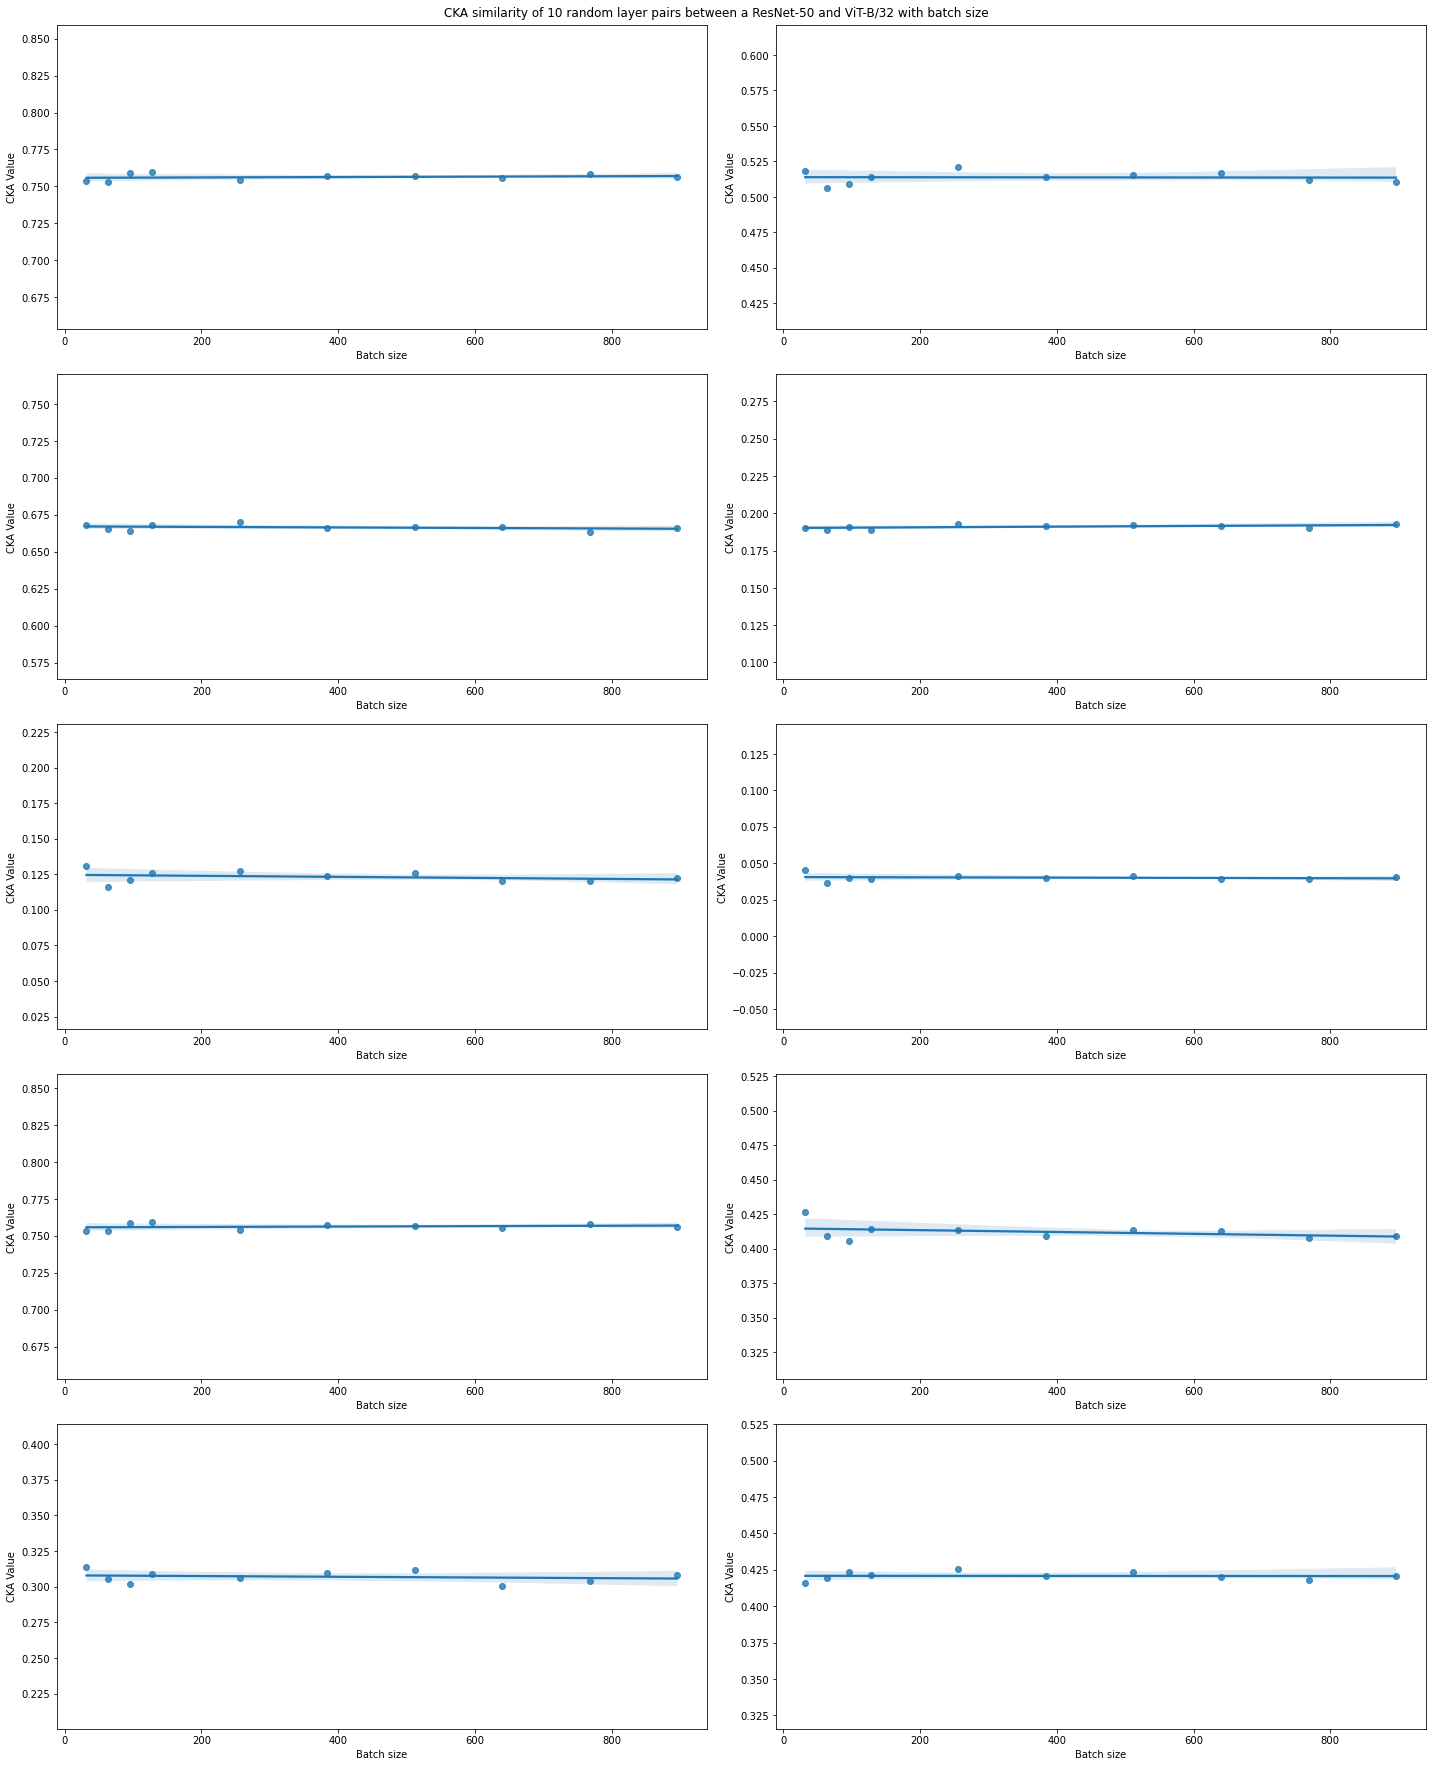

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(20,25))
fig.suptitle('CKA similarity of 10 random layer pairs between a ResNet-50 and ViT-B/32 with batch size')

for fig_num in range(10):

    i = random.randint(0, 9)
    j = random.randint(0, 9)

    x = [k for k in sim_mat_ct]
    y = [sim_mat_ct[k][i][j].item() for k in sim_mat_ct]

    df = pd.DataFrame({'Batch size': x, 'CKA Value': y})

    sns.regplot(ax = axes[fig_num%5][int(fig_num/5)], x='Batch size', y='CKA Value', data=df)
    axes[fig_num%5][int(fig_num/5)].set(ylim=(min(y)-0.1, max(y)+0.1))

fig.tight_layout()
fig.subplots_adjust(top=0.97)